# 假设检验
## 经典假设检验
- “直观效应”：第一胎和其他胎的区别。
- 经典假设检验的目的是回答一个问题：“给定一个样本和一个直观效应，这个效应是偶然出现的概率为多少？”
- 回答步骤：
    - 选择一个检验统计量（test statistic），对直观效应进行量化。直观效应：第一胎和其他胎的妊娠时间存在差异，因此很自然选择这两个群组的均值作为检验统计量。
    - 定义原假设（null hypothesis）。原假设是系统的一个模型，所基于的假设是直观效应不为真（直观效应是偶然产生的）。原假设：第一胎和其他胎没有区别，即两个群组的妊娠时间具有相同的分布。
    - 计算p值（p value）。p值是在原假设为真时，直观效应的概率。我们将计算两个群组均值的实际差异，然后计算在原假设为真的情况下，这个差异等于或大于实际值的概率。
    - 解释结果。如果p值很低，那么我们称这个效应是统计显著（statistically significant）的，即不太可能是偶然发生的。在这种情况下，我们推断，这个效应在大规模总体中出现的可能性更大。
    
假设投一枚硬币250次，结果得到140次正面，110次反面。基于这个结果怀疑这个硬币质地不均匀。结果在0.06，如果硬币是质地均匀的，预期6%可能性看到正面和反面的差值达到30的情况。按照惯例，5%是统计显著的阈值，如果p值小于5%，那么我们认为该效应是显著的，否则不是。

In [1]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import pandas
import random
import math
import thinkstats2
import thinkplot
import nsfg

In [2]:
class CoinTest(thinkstats2.HypothesisTest):
    """Tests the hypothesis that a coin is fair."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

# run the coin test
ct = CoinTest((140, 110))
pvalue = ct.PValue()
print ('coin test p-value', pvalue)

coin test p-value 0.059


## 检验均值差和其他统计量
最常检验的效应之一是两组样本的均值差。例如全国家庭增长数据，测试第一胎和其他胎妊娠时间差异。

- 置换（permutation）：从两组中取值混排，分为大小为n和m两个组，以此模拟原假设。
- 单侧（one-sided）：之前是双侧（two-sided）检验。如果我们有理由认为第一胎可能出生较晚，那么就不应该检验差值，而是使用单侧检验。
- 检验标准差的差值

三种检验p值都很大，所以这个效应不是统计显著的。

In [4]:
def MakeFrames():
    """Reads pregnancy data and partitions first babies and others.

    returns: DataFrames (all live births, first babies, others)
    """
    preg = nsfg.ReadFemPreg()

    live = preg[preg.outcome == 1]
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    assert len(live) == 9148
    assert len(firsts) == 4413
    assert len(others) == 4735

    return live, firsts, others
live, firsts, others = MakeFrames()


prglngth

means permute two-sided
p-value = 0.151
actual = 0.0780372667775
ts max = 0.183327219593

means permute one-sided
p-value = 0.088
actual = 0.0780372667775
ts max = 0.166034355154

std permute one-sided
p-value = 0.1
actual = 0.17600895914
ts max = 0.339693796308


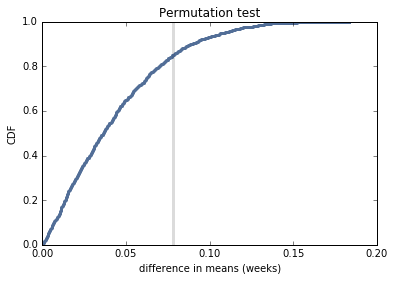

In [5]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    """Tests a difference in means by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data


class DiffMeansOneSided(DiffMeansPermute):
    """Tests a one-sided difference in means by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat


class DiffStdPermute(DiffMeansPermute):
    """Tests a one-sided difference in standard deviation by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

    
def PrintTest(p_value, ht):
    """Prints results from a hypothesis test.

    p_value: float
    ht: HypothesisTest
    """
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())


def RunTests(data, iters=1000):
    """Runs several tests on the given data.

    data: pair of sequences
    iters: number of iterations to run
    """

    # test the difference in means
    ht = DiffMeansPermute(data)
    p_value = ht.PValue(iters=iters)
    print('\nmeans permute two-sided')
    PrintTest(p_value, ht)

    ht.PlotCdf()
    thinkplot.Config(root='hypothesis1',
                   title='Permutation test',
                   xlabel='difference in means (weeks)',
                   ylabel='CDF',
                   legend=False) 
    
    # test the difference in means one-sided
    ht = DiffMeansOneSided(data)
    p_value = ht.PValue(iters=iters)
    print('\nmeans permute one-sided')
    PrintTest(p_value, ht)

    # test the difference in std
    ht = DiffStdPermute(data)
    p_value = ht.PValue(iters=iters)
    print('\nstd permute one-sided')
    PrintTest(p_value, ht)

# compare pregnancy lengths
print('\nprglngth')
data = firsts.prglngth.values, others.prglngth.values
RunTests(data)

第一组数据（置换检验）：CDF与观察到的差值（0.07）在0.82（即p值0.18的补）处相交。

In [6]:
# compare birth weights
print('\nbirth weight')
data = (firsts.totalwgt_lb.dropna().values,
        others.totalwgt_lb.dropna().values)
ht = DiffMeansPermute(data)
p_value = ht.PValue(iters=1000)
print('means permute two-sided')
PrintTest(p_value, ht)


birth weight
means permute two-sided
p-value = 0.0
actual = 0.124761184535
ts max = 0.0899775334883


使用新生儿体重进行分析，得到p值为0。运行1000次模拟，均值差都没有达到观察到的差值0.12磅。因此，我们将报告p<0.001，得出结论为，新生儿体重的差值是统计显著的。

## 检验相关性
- 检验的原假设是母亲年龄和新生儿体重之间没有相关性。我们可以将观察值混排进行模拟。
- TestStatistic计算Pearson相关性的绝对值。RunModel将xs进行混排，返回模拟数据。
- 实际数据的相关性为0.07。检验计算得到的p值为0。在1000次重复试验中，模拟得到的最大相关性0.04。因此，虽然观察到的变量相关性很小，但这种相关性是统计显著的。
- “统计显著”不一定说明一个效应是重要的，或者在实践中是显著的。只说明一个效应不太可能是偶然产生的。

In [7]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    """Tests correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
# test correlation
live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = live2.agepreg.values, live2.totalwgt_lb.values
ht = CorrelationPermute(data)
p_value = ht.PValue()
print('\nage weight correlation 2')
PrintTest(p_value, ht)


age weight correlation 2
p-value = 0.0
actual = 0.0688339703541
ts max = 0.031025636795


## 检验比例与卡方检验
检验骰子是否有问题，将骰子掷了60次，结果如下：

| 点数 | 频数 |
| --- | --- |
| 1 | 8 |
| 2 | 9 |
| 3 | 19 |
| 4 | 5 |
| 5 | 8 |
| 6 | 11 |

### 偏差总和统计量
每个点数平均出现10次，在这个数据集中，3出现的次数较多，4较少。这些差异统计显著嘛？在这个例子中，我们计算出每个值的预期频数、预期频数与观察频数的差值，以及差值绝对值的和。检验统计量是差值绝对值的和。计算的到p值为0.13，我们预期检验统计量达到或超过观察值的概率为13%，因此，这个直观效应不是统计显著的。

### 卡方统计量
$x^2=\sum_i\frac{(O_i-E_i)^2}{E_i}$

其中$O_i$是观察频数，$E_i$是预期频数。

In [8]:
class DiceTest(thinkstats2.HypothesisTest):
    """Tests whether a six-sided die is fair."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: list of frequencies
        """
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        n = sum(self.data)
        values = [1,2,3,4,5,6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

class DiceChiTest(DiceTest):
    """Tests a six-sided die using a chi-squared statistic."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: list of frequencies
        """
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

def RunDiceTest():
    """Tests whether a die is fair.
    """
    data = [8, 9, 19, 5, 8, 11]
    dt = DiceTest(data)
    print('dice test', dt.PValue(iters=10000))
    dt = DiceChiTest(data)
    print('dice chi test', dt.PValue(iters=10000))
# run the dice test
RunDiceTest()

dice test 0.1279
dice chi test 0.0438


使用卡方统计量计算的p值为0.04，明显小于使用偏差和的值0.13，如果我们坚持使用5%的阈值，就会认为受检测的效应是统计显著的。但是，将这两个检验放在一起考虑，结果并不明确。

这个例子告诉我们：p值取决于检验统计量的选择和原假设模型，有时这些因素决定了一个效应是否统计显著。

In [9]:
class PregLengthTest(thinkstats2.HypothesisTest):
    """Tests difference in pregnancy length using a chi-squared statistic."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: pair of lists of pregnancy lengths
        """
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        """Computes the chi-squared statistic.
        
        lengths: sequence of lengths

        returns: float
        """
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
# compare pregnancy lengths (chi-squared)
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('\npregnancy length chi-squared')
PrintTest(p_value, ht)


pregnancy length chi-squared
p-value = 0.0
actual = 101.501414829
ts max = 26.3476744126


用卡方统计量检验第一胎和其他胎的妊娠时间：全国家庭增长调查数据的总卡方统计量为102，这个数字本身没有什么意义。但在原假设下，1000次重复产生的最大验证统计量是30。对比之下，我们认为观察到的卡方统计量在原假设下不太可能出现，因此这个直观效应是统计显著的。

这个例子说明卡方检验存在一个局限：卡方检验可以证明两个群组之间存在差异，但不能揭示这个差异是什么。

## 误差
- 误报率（false positive rate）：如果一个效应的确是偶然发生的，那么我们将它误判为统计显著的概率是多少？
- 漏报率（false negative rate）：如果一个效应不是偶然发生的，那么假设检验失败的概率是多少？

如果阈值为5%，那么漏报率就是5%，理由如下：
- 如果效应不为真，那么原假设成立，因此，通过模拟原假设就可以计算出检验统计量的分布。我们将这个分布称为$CDF_T$。
- 重复运行实验，每次得到一个来自$CDF_T$的测试统计量t。随后，我们计算出p值。p值是$CDF_T$中随机值大于t的概率，即$1-CDF_T(t)$。
- 当$CDF_T(t)$大于95%，即t大于第95百分秩时，p值小于5%。而$CDF_T$中随机抽取的值大于第95百分秩的概率为多少？答案是5%。

因此，如果你进行一个阈值为5%的假设检验，20次里会有1次漏报。

## 功效
误报率受实际效应大小的影响，而通常我们无法得知实际效应的大小，因此误报率较难计算。一个办法是计算一个假定效应大小的误报率。

检验妊娠时间，结果约为70%。这个结果说明，如果妊娠时间均值的实际差异为0.78周，那么我们预期，如果使用这个规模的样本进行实验，结果有70%的可能性为误报。

另一种方式描述结果：如果实际差异为0.78周，那么我们预期检验通过的可能性只有30%。这个“正确通过率”称为检验的功效(power)，有时也称为“敏感度”（sensitivity）。这个值反映了一个检验检测出指定大小效应的能力。

在这个示例中，这个检验结果通过的可能性只有30%（假设实际差异为0.78周）。一般来说，我们认为80%的功效是可接受的，因此示例中的检验属于“低功效的”（underpowered）。

通常，假设检验失败并不说明两个群组之间不存在差异，而是说，如果差异的确存在的话，这个差异太小，以至于无法在这种规模的样本中检测到。

In [10]:
def FalseNegRate(data, num_runs=1000):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs
# compute the false negative rate for difference in pregnancy length
data = firsts.prglngth.values, others.prglngth.values
neg_rate = FalseNegRate(data)
print('false neg rate', neg_rate)

false neg rate 0.701


## 复现
第一版使用的是全国家庭增长调查的第6周期数据，发布于2002年。2011年10月，疾病控制和预防中心发布了基于2006~2010年调查附加数据。nsfg2.py中包含读取和清洗这些数据的代码。在这个心数据集中：
- 妊娠时间均值差为0.16周，p<0.001，是统计显著的（原始数据中均值差为0.078周）
- 新生儿体重的差值为0.17磅，p<0.001（原始数据中差值为0.12磅）
- 新生儿体重与母亲年龄之间的相关性为0.08，p<0.001（原始数据中相关性为0.07）
- 卡方检验结果p<0.001，是统计显著的（原始数据也是如此）

原始数据中所有统计显著的效应，在新数据集中得到了复现。此外，妊娠时间差值在原始数据中不显著，在新数据集中这个差值变大，由不显著变为显著。

In [12]:
def ReplicateTests():    
    """Replicates tests with the new NSFG data."""
    import nsfg2
    live, firsts, others = nsfg2.MakeFrames()

    # compare pregnancy lengths
    print('\nprglngth2')
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p_value = ht.PValue(iters=1000)
    print('means permute two-sided')
    PrintTest(p_value, ht)

    print('\nbirth weight 2')
    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p_value = ht.PValue(iters=1000)
    print('means permute two-sided')
    PrintTest(p_value, ht)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p_value = ht.PValue()
    print('\nage weight correlation 2')
    PrintTest(p_value, ht)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p_value = ht.PValue()
    print('\npregnancy length chi-squared 2')
    PrintTest(p_value, ht)
# run the tests with new nsfg data
ReplicateTests()


prglngth2
means permute two-sided
p-value = 0.0
actual = 0.164708338667
ts max = 0.14194274494

birth weight 2
means permute two-sided
p-value = 0.0
actual = 0.170870412946
ts max = 0.0930818843361

age weight correlation 2
p-value = 0.0
actual = 0.0808183040947
ts max = 0.0305377196587

pregnancy length chi-squared 2
p-value = 0.0
actual = 145.214547488
ts max = 25.6167521177
